In [14]:
import pandas as pd
import numpy as np

In [15]:
df=pd.read_csv("amazon.csv")

In [16]:
# Cleaning functions
def clean_price(x):
    if isinstance(x, str):
        return float(x.replace("₹", "").replace(",", "").strip())
    return np.nan

def clean_rating(x):
    try:
        return float(x)
    except:
        return np.nan

def clean_rating_count(x):
    try:
        return int(str(x).replace(",", ""))
    except:
        return np.nan

In [17]:
# Extract top-level category
df['top_category'] = df['category'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else 'Unknown')

# Clean numerical fields
df['discounted_price_clean'] = df['discounted_price'].apply(clean_price)
df['actual_price_clean'] = df['actual_price'].apply(clean_price)
df['discount_percentage_clean'] = df['discount_percentage'].str.replace('%', '').astype(float)
df['rating_clean'] = df['rating'].apply(clean_rating)
df['rating_count_clean'] = df['rating_count'].apply(clean_rating_count)

In [18]:
# Define sharding thresholds
high_rating_threshold = df['rating_count_clean'].quantile(0.9)
high_discount_threshold = 50.0

In [19]:
# Assign shard
def assign_shard(row):
    category = row['top_category'].replace(" ", "_")
    activity_level = 'high' if row['rating_count_clean'] >= high_rating_threshold else 'low'
    discount_level = 'high' if row['discount_percentage_clean'] >= high_discount_threshold else 'low'
    return f"{category}_{activity_level}_activity_{discount_level}_discount"

df['shard_id'] = df.apply(assign_shard, axis=1)


In [20]:
# Save to CSV
df.to_csv("amazone_adaptive_sharded.csv", index=False)

print("✅ Adaptive sharding completed and saved to 'amazone_adaptive_sharded.csv'")

✅ Adaptive sharding completed and saved to 'amazone_adaptive_sharded.csv'


In [21]:
import pandas as pd

# Load the cleaned and sharded dataset
df = pd.read_csv("amazone_adaptive_sharded.csv")

# Extract shard metadata components
shard_meta = df.copy()
shard_meta[['meta_category', 'meta_activity', '_1', 'meta_discount', '_2']] = \
    shard_meta['shard_id'].str.split('_', expand=True)
# Normalize key fields for consistent matching
shard_meta['meta_category'] = shard_meta['meta_category'].str.strip().str.lower()
shard_meta['meta_activity'] = shard_meta['meta_activity'].str.strip().str.lower()
shard_meta['meta_discount'] = shard_meta['meta_discount'].str.strip().str.lower()


# Group and compute aggregate statistics
shard_metadata = shard_meta.groupby('shard_id').agg(
    top_category=('meta_category', 'first'),
    activity_level=('meta_activity', 'first'),
    discount_level=('meta_discount', 'first'),
    product_count=('product_id', 'count'),
    avg_rating=('rating_clean', 'mean'),
    avg_discount_percent=('discount_percentage_clean', 'mean'),
    avg_review_count=('rating_count_clean', 'mean')
).reset_index()

# Save to JSON
shard_metadata.to_json("shard_metadata.json", orient="records", indent=2)

print("✅ Shard metadata saved to 'shard_metadata.json'")


✅ Shard metadata saved to 'shard_metadata.json'


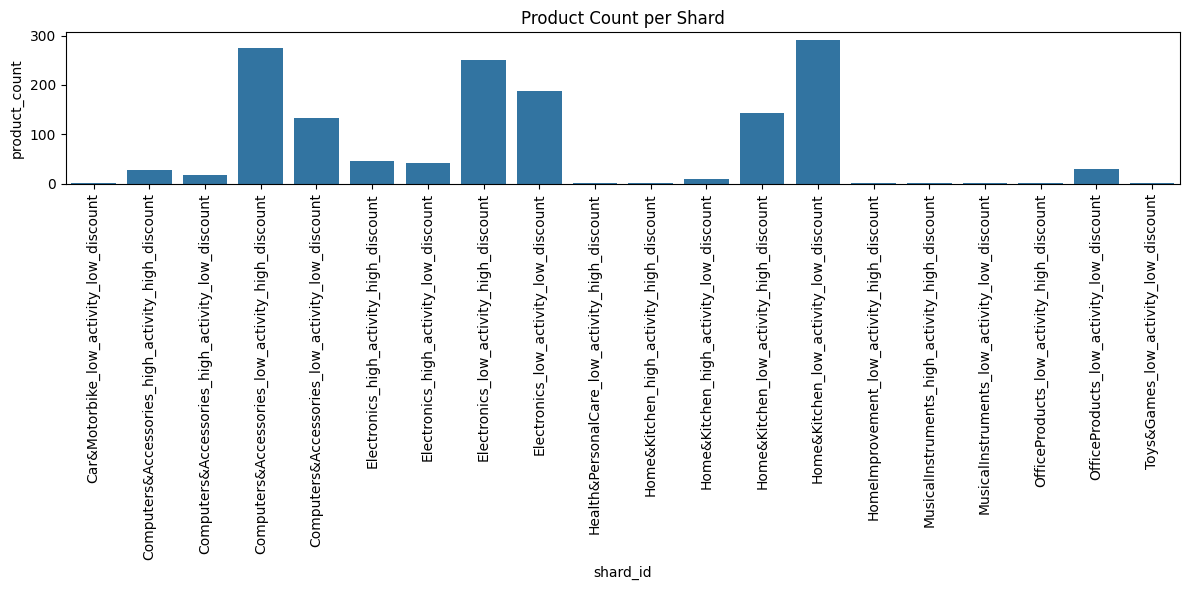

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
shard_metadata=pd.read_json("shard_metadata.json")
# Bar plot: Product count per shard
plt.figure(figsize=(12, 6))
sns.barplot(data=shard_metadata, x='shard_id', y='product_count')
plt.xticks(rotation=90)
plt.title("Product Count per Shard")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import json

# Load dataset and shard metadata
df = pd.read_csv("amazone_adaptive_sharded.csv")

with open("shard_metadata.json", "r") as f:
    shard_info = json.load(f)

# Extract unique categories and discount levels
categories = sorted(set(shard["top_category"] for shard in shard_info))
discount_levels = sorted(set(shard["discount_level"] for shard in shard_info))

print("Available Categories:")
for cat in categories:
    print(f"- {cat}")

print("\nAvailable Discount Levels:")
for disc in discount_levels:
    print(f"- {disc}")

def find_best_match(input_str, options):
    input_str = input_str.lower()
    for option in options:
        if input_str in option.lower():
            return option
    return None

# Get partial input from user and find best match
category_input = input("\nEnter product category (partial allowed): ").strip()
category = find_best_match(category_input, categories)
while category is None:
    print("No matching category found. Please try again.")
    category_input = input("Enter product category (partial allowed): ").strip()
    category = find_best_match(category_input, categories)

discount_input = input("Enter discount level (partial allowed): ").strip()
discount_level = find_best_match(discount_input, discount_levels)
while discount_level is None:
    print("No matching discount level found. Please try again.")
    discount_input = input("Enter discount level (partial allowed): ").strip()
    discount_level = find_best_match(discount_input, discount_levels)

new_product = {
    "category": category,
    "discount_level": discount_level
}

def route_product(new_product):
    for shard in shard_info:
        if (shard["top_category"] == new_product["category"] and
            shard["discount_level"] == new_product["discount_level"]):
            return shard["shard_id"]
    return "default_fallback"

assigned_shard = route_product(new_product)

print(f"\nProduct routed to shard: {assigned_shard}")

# Display products in that shard
def show_products_in_shard(shard_id):
    shard_products = df[df['shard_id'] == shard_id]
    if shard_products.empty:
        print(f"No products found in shard: {shard_id}")
    else:
        print(f"\nProducts in shard '{shard_id}':\n")
        # Adjust columns as per your dataset
        print(shard_products[['product_id', 'product_name', 'rating_clean', 'discount_percentage_clean']].to_string(index=False))

show_products_in_shard(assigned_shard)


Available Categories:
- Car&Motorbike
- Computers&Accessories
- Electronics
- Health&PersonalCare
- Home&Kitchen
- HomeImprovement
- MusicalInstruments
- OfficeProducts
- Toys&Games

Available Discount Levels:
- high
- low
No matching category found. Please try again.
No matching category found. Please try again.

Product routed to shard: Home&Kitchen_high_activity_high_discount

Products in shard 'Home&Kitchen_high_activity_high_discount':

product_id                                                                                                                                              product_name  rating_clean  discount_percentage_clean
B01LWYDEQ7 Pigeon Polypropylene Mini Handy and Compact Chopper with 3 Blades for Effortlessly Chopping Vegetables and Fruits for Your Kitchen (12420, Green, 400 ml)           4.1                       60.0
B09X5C9VLK Lifelong LLMG23 Power Pro 500-Watt Mixer Grinder with 3 Jars (Liquidizing, Wet Grinding and Chutney Jar), Stainless Steel blades, 1

In [ ]:


import json
import pandas as pd
import random
import time
import os
from sentence_transformers import SentenceTransformer, util

# === Load semantic model ===
model = SentenceTransformer('all-MiniLM-L6-v2')

# === Load shard metadata ===
with open("shard_metadata.json", "r") as f:
    shard_info = json.load(f)

# === Extract unique categories and discount levels ===
categories = sorted(set(shard["top_category"] for shard in shard_info))
discount_levels = sorted(set(shard["discount_level"] for shard in shard_info))

print("Available Categories:")
for cat in categories:
    print(f"- {cat}")

print("\nAvailable Discount Levels:")
for disc in discount_levels:
    print(f"- {disc}")

# === Embedding helper functions ===
def get_embeddings(options):
    return model.encode(options, convert_to_tensor=True)

def find_best_semantic_match(input_str, options, embeddings):
    input_embedding = model.encode(input_str, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(input_embedding, embeddings)[0]
    best_idx = cosine_scores.argmax().item()
    best_score = cosine_scores[best_idx].item()
    if best_score > 0.5:  
        return options[best_idx]
    return None

# === Product routing logic ===
def route_product(new_product):
    for shard in shard_info:
        if (shard["top_category"] == new_product["category"] and
            shard["discount_level"] == new_product["discount_level"]):
            return shard["shard_id"]
    return "default_fallback"

# === Access log setup ===
access_log_file = "shard_access_log.csv"

# Load existing log if it exists
if os.path.exists(access_log_file):
    access_log_df = pd.read_csv(access_log_file)
    access_log = access_log_df.to_dict("records")
else:
    access_log = []

# === Compute embeddings ===
category_embeddings = get_embeddings(categories)
discount_embeddings = get_embeddings(discount_levels)

print("\n🔍 Semantic embeddings loaded. Ready for input...\n")

# === Main query loop ===
while True:
    print("\n New User Query:")

    category_input = input("Enter product category: ").strip()
    category = find_best_semantic_match(category_input, categories, category_embeddings)

    while category is None:
        print(" No matching category found. Please try again.")
        category_input = input("Enter product category (partial allowed): ").strip()
        category = find_best_semantic_match(category_input, categories, category_embeddings)

    discount_input = input("Enter discount level (partial allowed): ").strip()
    discount_level = find_best_semantic_match(discount_input, discount_levels, discount_embeddings)

    while discount_level is None:
        print(" No matching discount level found. Please try again.")
        discount_input = input("Enter discount level (partial allowed): ").strip()
        discount_level = find_best_semantic_match(discount_input, discount_levels, discount_embeddings)

    new_product = {"category": category, "discount_level": discount_level}
    assigned_shard = route_product(new_product)

    print(f" Product routed to shard: {assigned_shard}")

    # latency = round(random.uniform(50, 400), 2)
    start_time = time.perf_counter()

    # Perform actual routing logic
    assigned_shard = route_product(new_product)

    end_time = time.perf_counter()
    latency = round((end_time - start_time) * 1000, 2)

    access_log.append({
        "timestamp": time.time(),
        "shard_id": assigned_shard,
        "latency_ms": latency
    })

    # Save updated access log
    pd.DataFrame(access_log).to_csv(access_log_file, index=False)

    more = input("Do you want to enter another product query? (y/n): ").strip().lower()
    if more != 'y':
        print(" Shard access log saved to 'shard_access_log.csv'")
        break


Available Categories:
- car&motorbike
- computers&accessories
- electronics
- health&personalcare
- home&kitchen
- homeimprovement
- musicalinstruments
- officeproducts
- toys&games

Available Discount Levels:
- high
- low

🔍 Semantic embeddings loaded. Ready for input...


 New User Query:
 Product routed to shard: Car&Motorbike_low_activity_low_discount

 New User Query:
 Product routed to shard: Computers&Accessories_high_activity_high_discount

 New User Query:
 Product routed to shard: Toys&Games_low_activity_low_discount
 Shard access log saved to 'shard_access_log.csv'


In [2]:
import pandas as pd

# Load the shard metadata and access log
shard_metadata = pd.read_json("shard_metadata.json")
shard_access_df = pd.read_csv("shard_access_log.csv")

# Group by shard and calculate load statistics
shard_load_stats = shard_access_df.groupby("shard_id").agg(
    access_count=('shard_id', 'count'),
    avg_latency_ms=('latency_ms', 'mean'),
    max_latency_ms=('latency_ms', 'max'),
    p95_latency_ms=('latency_ms', lambda x: x.quantile(0.95))  # Optional: 95th percentile
).reset_index()

# Merge with shard metadata
load_monitor_df = pd.merge(shard_metadata, shard_load_stats, on="shard_id", how="left").fillna(0)

# Sort by access count (or change to 'avg_latency_ms' if preferred)
load_monitor_df = load_monitor_df.sort_values(by='access_count', ascending=False)

# Display key monitoring columns
print("\n📊 Top Shard Load Stats:")
print(load_monitor_df[[
    'shard_id', 'top_category', 'discount_level',
    'access_count', 'avg_latency_ms', 'max_latency_ms', 'p95_latency_ms',
    'product_count'
]])



📊 Top Shard Load Stats:
                                             shard_id           top_category  \
2    Computers&Accessories_high_activity_low_discount  computers&accessories   
16       MusicalInstruments_low_activity_low_discount     musicalinstruments   
18           OfficeProducts_low_activity_low_discount         officeproducts   
6              Electronics_high_activity_low_discount            electronics   
17          OfficeProducts_low_activity_high_discount         officeproducts   
19               Toys&Games_low_activity_low_discount             toys&games   
10           Home&Kitchen_high_activity_high_discount           home&kitchen   
9      Health&PersonalCare_low_activity_high_discount    health&personalcare   
14         HomeImprovement_low_activity_high_discount        homeimprovement   
1   Computers&Accessories_high_activity_high_discount  computers&accessories   
0             Car&Motorbike_low_activity_low_discount          car&motorbike   
5             E

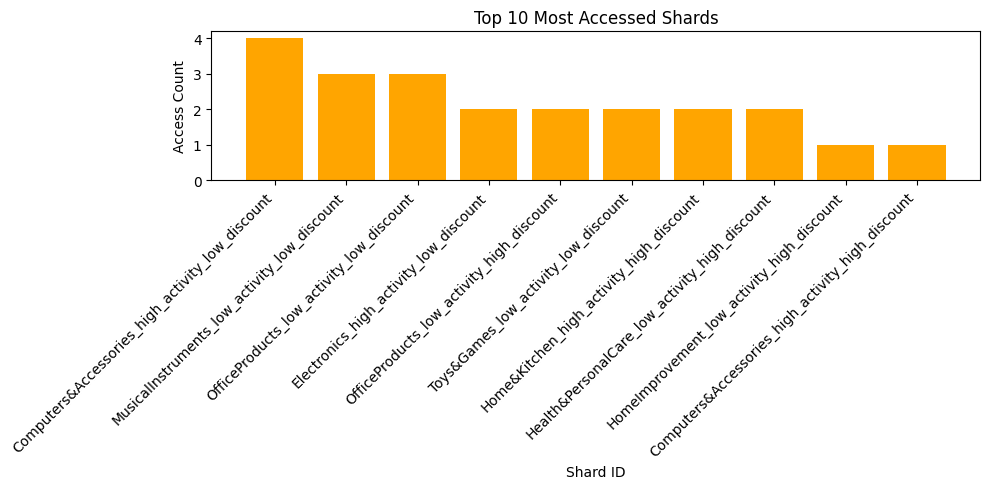

In [3]:
import matplotlib.pyplot as plt

top_n = load_monitor_df.head(10)
plt.figure(figsize=(10, 5))
plt.bar(top_n['shard_id'], top_n['access_count'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Accessed Shards")
plt.xlabel("Shard ID")
plt.ylabel("Access Count")
plt.tight_layout()
plt.show()


In [4]:
hot_shards = load_monitor_df[
    (load_monitor_df['access_count'] > load_monitor_df['access_count'].mean() + 2 * load_monitor_df['access_count'].std()) |
    (load_monitor_df['avg_latency_ms'] > 300)
]

print("🔥 Hot Shards Detected:")
print(hot_shards[['shard_id', 'access_count', 'avg_latency_ms']])


🔥 Hot Shards Detected:
                                           shard_id  access_count  \
2  Computers&Accessories_high_activity_low_discount           4.0   
5           Electronics_high_activity_high_discount           1.0   

   avg_latency_ms  
2           51.24  
5          339.79  


<Axes: title={'center': 'Shard Query Load Over Time (1-min intervals)'}, xlabel='timestamp'>

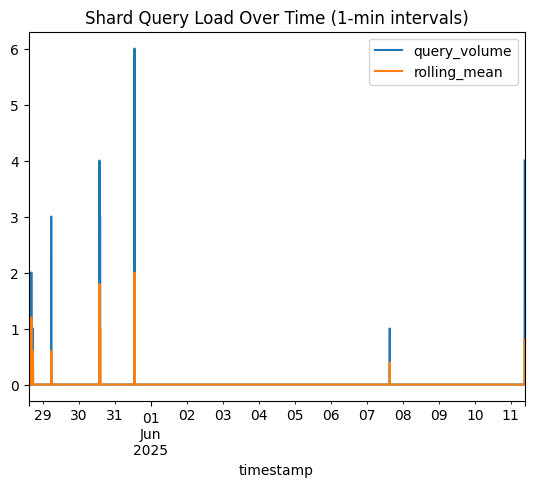

In [5]:
# For example: simple rolling average forecast
shard_access_df['timestamp'] = pd.to_datetime(shard_access_df['timestamp'], unit='s')
shard_access_df.set_index('timestamp', inplace=True)

shard_hourly = shard_access_df.resample('1Min').agg({'shard_id': 'count'})
shard_hourly.rename(columns={'shard_id': 'query_volume'}, inplace=True)

shard_hourly['rolling_mean'] = shard_hourly['query_volume'].rolling(window=5).mean()
shard_hourly.plot(title="Shard Query Load Over Time (1-min intervals)")


In [6]:
import pandas as pd

# Load access log
log_df = pd.read_csv("shard_access_log.csv")

# Count access frequency and average latency
shard_stats = log_df.groupby("shard_id").agg({
    "latency_ms": ["count", "mean"]
}).reset_index()

shard_stats.columns = ["shard_id", "access_count", "avg_latency"]
print(shard_stats.sort_values(by="access_count", ascending=False))


                                             shard_id  access_count  \
14                                   default_fallback            22   
2    Computers&Accessories_high_activity_low_discount             4   
10       MusicalInstruments_low_activity_low_discount             3   
12           OfficeProducts_low_activity_low_discount             3   
6            Home&Kitchen_high_activity_high_discount             2   
5      Health&PersonalCare_low_activity_high_discount             2   
4              Electronics_high_activity_low_discount             2   
13               Toys&Games_low_activity_low_discount             2   
11          OfficeProducts_low_activity_high_discount             2   
0             Car&Motorbike_low_activity_low_discount             1   
1   Computers&Accessories_high_activity_high_discount             1   
3             Electronics_high_activity_high_discount             1   
9      MusicalInstruments_high_activity_high_discount             1   
7     

In [7]:
MAX_ACCESS_THRESHOLD = 50     # Max number of accesses before we rebalance
MAX_LATENCY_THRESHOLD = 300   # ms


In [8]:
overloaded_shards = shard_stats[
    (shard_stats["access_count"] > MAX_ACCESS_THRESHOLD) |
    (shard_stats["avg_latency"] > MAX_LATENCY_THRESHOLD)
]
print("Overloaded shards:\n", overloaded_shards)


Overloaded shards:
                                   shard_id  access_count  avg_latency
3  Electronics_high_activity_high_discount             1       339.79


In [9]:
underutilized_shards = shard_stats[
    (shard_stats["access_count"] < 10) & 
    (shard_stats["avg_latency"] < 200)
]
print("Underutilized shards:\n", underutilized_shards)


Underutilized shards:
                                              shard_id  access_count  \
0             Car&Motorbike_low_activity_low_discount             1   
1   Computers&Accessories_high_activity_high_discount             1   
2    Computers&Accessories_high_activity_low_discount             4   
4              Electronics_high_activity_low_discount             2   
6            Home&Kitchen_high_activity_high_discount             2   
7             Home&Kitchen_high_activity_low_discount             1   
8          HomeImprovement_low_activity_high_discount             1   
9      MusicalInstruments_high_activity_high_discount             1   
10       MusicalInstruments_low_activity_low_discount             3   
11          OfficeProducts_low_activity_high_discount             2   
12           OfficeProducts_low_activity_low_discount             3   
13               Toys&Games_low_activity_low_discount             2   

    avg_latency  
0      0.000000  
1      0.000000  

In [10]:
import json
import random

# Load shard metadata
with open("shard_metadata.json", "r") as f:
    shard_info = json.load(f)

# Build lookup
shard_map = {shard["shard_id"]: shard for shard in shard_info}

# Reassign one category-discount pair from overloaded to underutilized shard
for _, row in overloaded_shards.iterrows():
    overloaded_id = row["shard_id"]
    for shard in shard_info:
        if shard["shard_id"] == overloaded_id:
            if underutilized_shards.shape[0] > 0:
                new_shard = random.choice(underutilized_shards["shard_id"].tolist())
                print(f"🔁 Moving category '{shard['top_category']}' with discount '{shard['discount_level']}' from {overloaded_id} to {new_shard}")
                shard["shard_id"] = new_shard


🔁 Moving category 'electronics' with discount 'high' from Electronics_high_activity_high_discount to HomeImprovement_low_activity_high_discount


In [11]:
# Merge load stats with shard metadata
full_shard_stats = pd.merge(shard_metadata, shard_load_stats, on='shard_id', how='left')

# Fill missing values in access stats (e.g., for unused shards)
full_shard_stats[['access_count', 'avg_latency_ms', 'max_latency_ms', 'p95_latency_ms']] = \
    full_shard_stats[['access_count', 'avg_latency_ms', 'max_latency_ms', 'p95_latency_ms']].fillna(0)

# Save to CSV or JSON
# full_shard_stats.to_csv("final_shard_stats.csv", index=False)
# print("✅ Final shard statistics saved to 'final_shard_stats.csv'")
# Save to JSON instead of CSV
# full_shard_stats.to_json("final_shard_stats.json", orient="records", lines=True)
# print("✅ Final shard statistics saved to 'final_shard_stats.json'")

# Save to a human-readable JSON file
full_shard_stats.to_json("final_shard_stats_pretty.json", orient="records", indent=4)

print("✅ Final shard statistics saved to 'final_shard_stats_pretty.json'")


✅ Final shard statistics saved to 'final_shard_stats_pretty.json'


C:\Users\DELL\AppData\Local\Temp\ipykernel_3472\1318313144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=full_shard_stats, x='shard_id', y='access_count', palette='coolwarm')


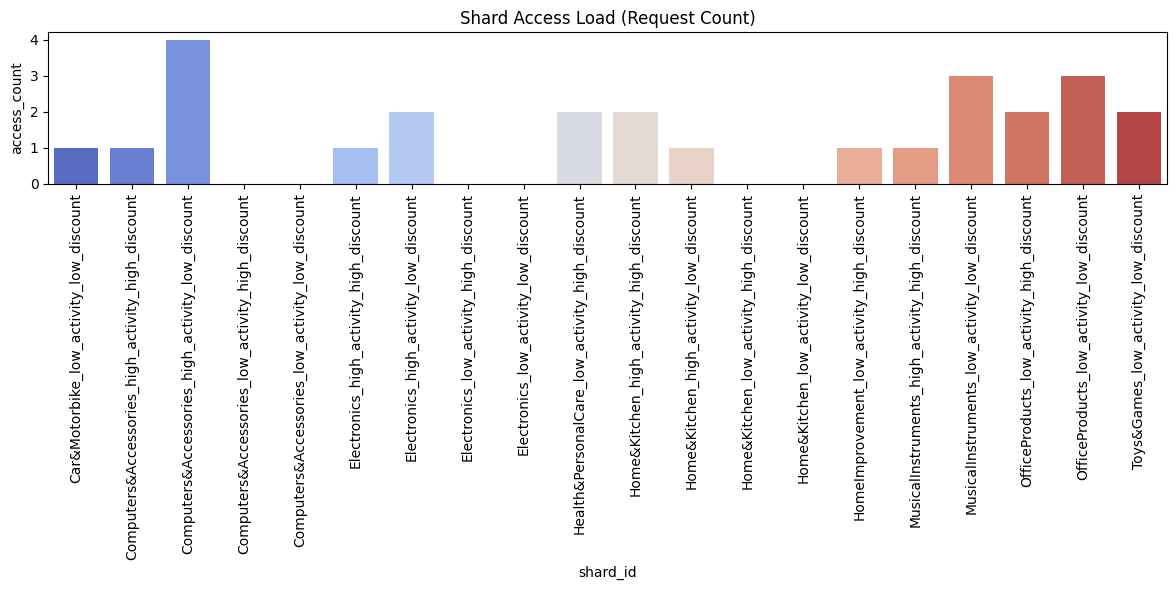

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=full_shard_stats, x='shard_id', y='access_count', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Shard Access Load (Request Count)")
plt.tight_layout()
plt.show()


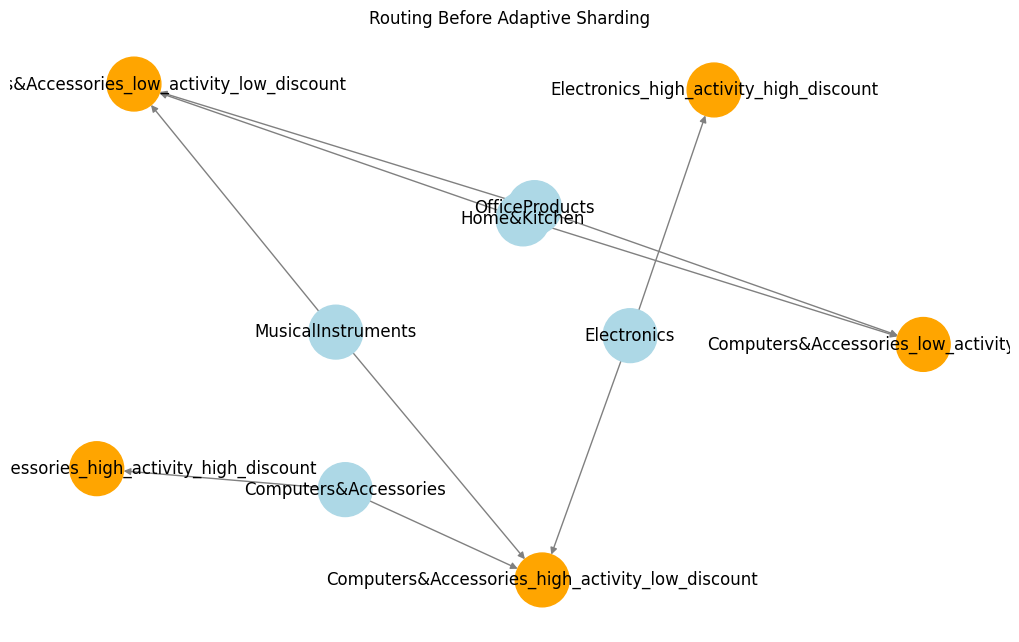

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample of categories and shards before and after sharding
categories = df['top_category'].unique()[:5]  # Select 5 for visualization
shards = df['shard_id'].unique()[:5]

# Build graph BEFORE adaptive sharding (random routing)
G_before = nx.DiGraph()
for cat in categories:
    G_before.add_node(cat, color='lightblue')
for shard in shards:
    G_before.add_node(shard, color='orange')

# Simulate random connections (static routing)
import random
for cat in categories:
    assigned_shards = random.sample(list(shards), k=2)
    for s in assigned_shards:
        G_before.add_edge(cat, s)

# Plot BEFORE
colors = [G_before.nodes[n]['color'] for n in G_before.nodes()]
plt.figure(figsize=(10,6))
nx.draw(G_before, with_labels=True, node_color=colors, node_size=1500, edge_color='gray')
plt.title("Routing Before Adaptive Sharding")
plt.show()


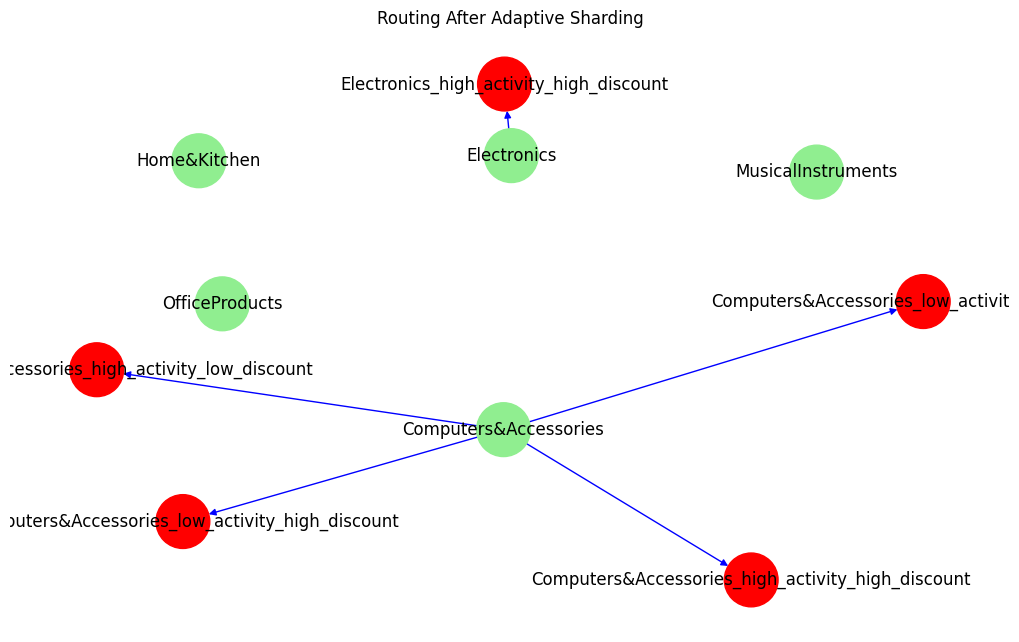

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Define categories and shards
categories = df['top_category'].unique()[:5]
adaptive_shards = df['shard_id'].unique()[:5]

# Step 2: Create a directed graph
G_after = nx.DiGraph()

# Step 3: Add nodes for categories and shards with colors
for cat in categories:
    G_after.add_node(cat, node_type='category', color='lightgreen')
for shard in adaptive_shards:
    G_after.add_node(shard, node_type='shard', color='red')

# Step 4: Add edges (routing logic)
sample_df = df[df['top_category'].isin(categories) & df['shard_id'].isin(adaptive_shards)].head(100)
for _, row in sample_df.iterrows():
    G_after.add_edge(row['top_category'], row['shard_id'])

# Step 5: Plot
colors = [G_after.nodes[n].get('color', 'gray') for n in G_after.nodes()]  # Default to gray if color missing
plt.figure(figsize=(10, 6))
nx.draw(G_after, with_labels=True, node_color=colors, node_size=1500, edge_color='blue')
plt.title("Routing After Adaptive Sharding")
plt.show()
